## Análisis

En este notebook vamos a hacer un análisis de las distintas competiciones (las cinco grandes ligas durante la temporada 2015-2016) y de todos los partidos en general para poder entender que características son más importantes a la hora de tomar la decisión por parte del modelo de ML para decidir si el equipo va a ganar, perder o empatar el partido.

In [1]:
import shap
import pandas as pd
import numpy as np

### La Liga temporada 2015/2016 (masculina)

Cargamos los datos de los partidos sobre La Liga en la temporada 2015/2016 masculina para entrenar el modelo y poder hacer el estudio de explicabilidad.

In [2]:
import os


competition_name = "La Liga"
competition_gender = "male"
season_name_for_filename = "2015_2016"

output_dir = "data/reduced/"
filename = f"{competition_name}({season_name_for_filename}_{competition_gender})_reduced.csv"
output_path = os.path.join(output_dir, filename)

if os.path.exists(output_path):
    print(f"Matches from the competition loaded from {output_path}")
    matches_in_LaLiga = pd.read_csv(output_path)
else:
    print("You don't have data from the competition yet. Please run the notebook '0_datasets_building.ipynb' first.")

Matches from the competition loaded from data/reduced/La Liga(2015_2016_male)_reduced.csv


In [3]:
matches_in_LaLiga.head(5)

,match_id,shots_on_target_ratio_home,shots_on_target_ratio_away,average_shots_on_target_distance_home,average_shots_on_target_distance_away,shots_inside_area_ratio_home,shots_inside_area_ratio_away,pass_success_ratio_home,pass_success_ratio_away,cross_success_ratio_home,...,percentage_shots_under_pressure_home,percentage_shots_inside_area_under_pressure_home,percentage_passes_under_pressure_home,percentage_passes_inside_area_under_pressure_home,percentage_set_piece_shots_home,percentage_set_piece_shots_inside_area_home,percentage_substitutions_home,percentage_tactical_substitutions_home,percentage_tactical_changes_home,percentage_formation_changes_home
0,3825565,0.400000,0.153846,20.462904,15.923442,0.600000,0.384615,0.630915,0.804089,0.000000,...,0.500000,1.000000,0.364780,0.000000,0.214286,0.285714,0.5,0.40,1.000000,0.5
1,3825564,0.312500,0.300000,25.239973,18.652679,0.187500,0.600000,0.759191,0.690647,0.285714,...,0.666667,0.000000,0.476190,0.333333,0.470588,0.000000,0.5,0.50,1.000000,1.0
2,266236,0.333333,0.400000,33.431447,11.773407,0.500000,0.700000,0.609065,0.809783,0.125000,...,0.166667,0.250000,0.196491,0.400000,0.333333,0.250000,0.5,0.75,0.666667,0.5
3,3825570,0.461538,0.400000,24.394269,9.439840,0.538462,0.800000,0.760377,0.676543,0.125000,...,0.500000,0.666667,0.582857,1.000000,0.600000,0.444444,0.5,0.60,0.500000,0.5
4,3825562,0.153846,0.200000,20.432657,19.849825,0.384615,0.800000,0.775176,0.700581,0.416667,...,0.500000,0.000000,0.555556,0.750000,0.615385,0.384615,0.5,0.50,0.600000,0.5


Una vez ya tenemos los datos cargados, entrenamos el mejor modelo y mostramos sus resultados.

In [4]:
from src.analysis import laliga_best_model


best_model_LaLiga, evaluation_metrics, X_train_reduced_LaLiga, X_test_reduced_LaLiga, X_test_reduced_orig_LaLiga, feature_names_reduced_LaLiga, encoder_LaLiga, match_ids_test = laliga_best_model(matches_in_LaLiga)
print(f"The best model for La Liga is {best_model_LaLiga}")
print(f"The evaluation metrics for the best model are:")
evaluation_metrics.head()

The best model for La Liga is LogisticRegression(C=0.29354310869235306, max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')
The evaluation metrics for the best model are:


,Train Accuracy,Test Accuracy,Precision Macro,Precision Weighted,Recall Macro,Recall Weighted,F1 Macro,F1 Weighted
Logistic Regression MI,0.766447,0.723684,0.702033,0.717442,0.684041,0.723684,0.690678,0.718346


Una vez ya tenemos el mejor modelo entrenado comenzamos el análisis de explicabilidad. Vamos a comenzar por un estudio global. 

En este caso, al ser el mejor modelo Logistic Regression, vamos a fijarnos en el coeficiente (método coef_) que nos aporta el modelo para cada característica en cada clase. 
- Con esto, estamos observando la importancia global de cada característica para cada clase en términos de una relación lineal. Es decir, estamos observando relaciones exclusivamente lineales entre las características y la predicción.
- Con esto, no se tiene en cuenta las interacciones entre características ni tampoco explica predicciones individuales.

Los gráficos que se aparecen a continuación muestran la importancia de cada característica para predecir una determinada clase de resultado en los partidos de LaLiga. Las clases son:
- Clase "away_team": Indica qué características influyen en que el equipo visitante gane el partido.
- Clase "draw": Indica qué características influyen en que el partido termine en empate.
- Clase "home_team": Indica qué características influyen en que el equipo local gane el partido.

Los valores representados en el eje X son los coeficientes de la regresión logística, que indican la magnitud e impacto de cada variable en la probabilidad de un resultado específico. Valores positivos aumentan la probabilidad de que ocurra esa clase, mientras que valores negativos disminuyen dicha probabilidad.

Clase 0: ['away_team']


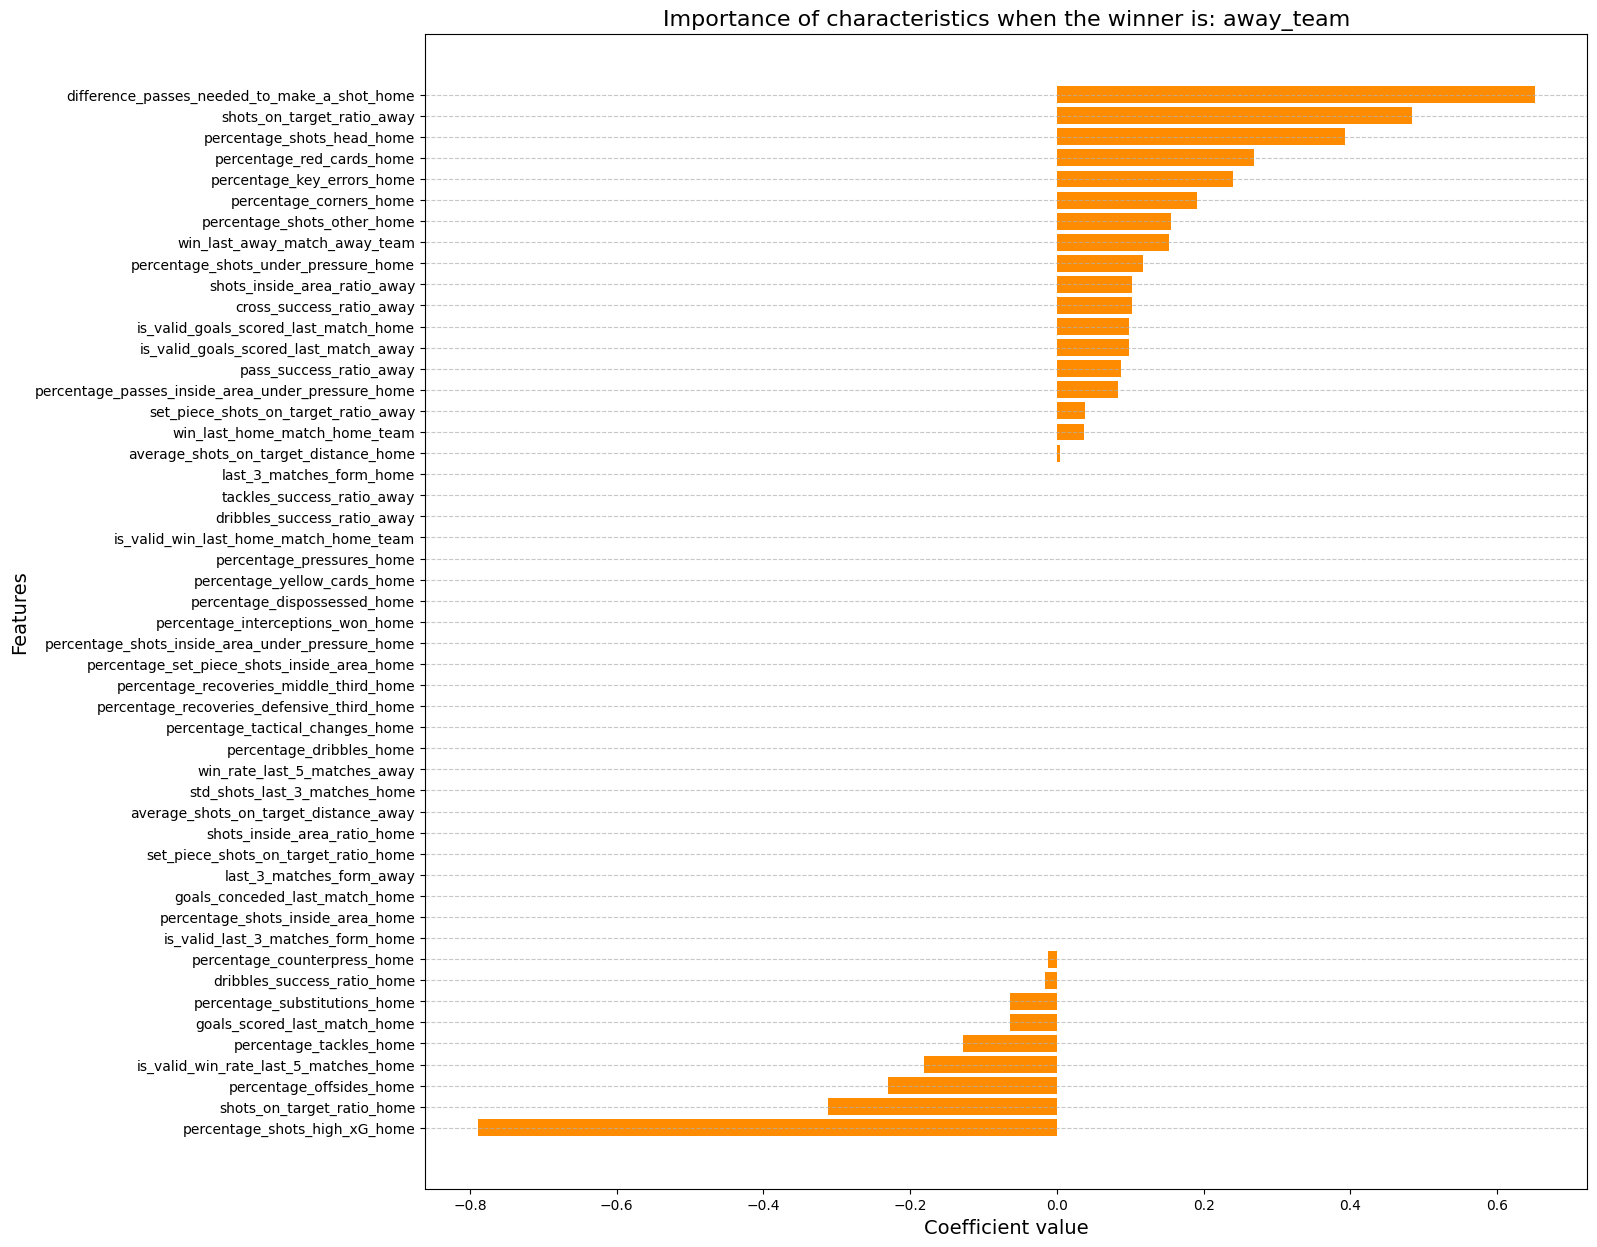

Clase 1: ['draw']


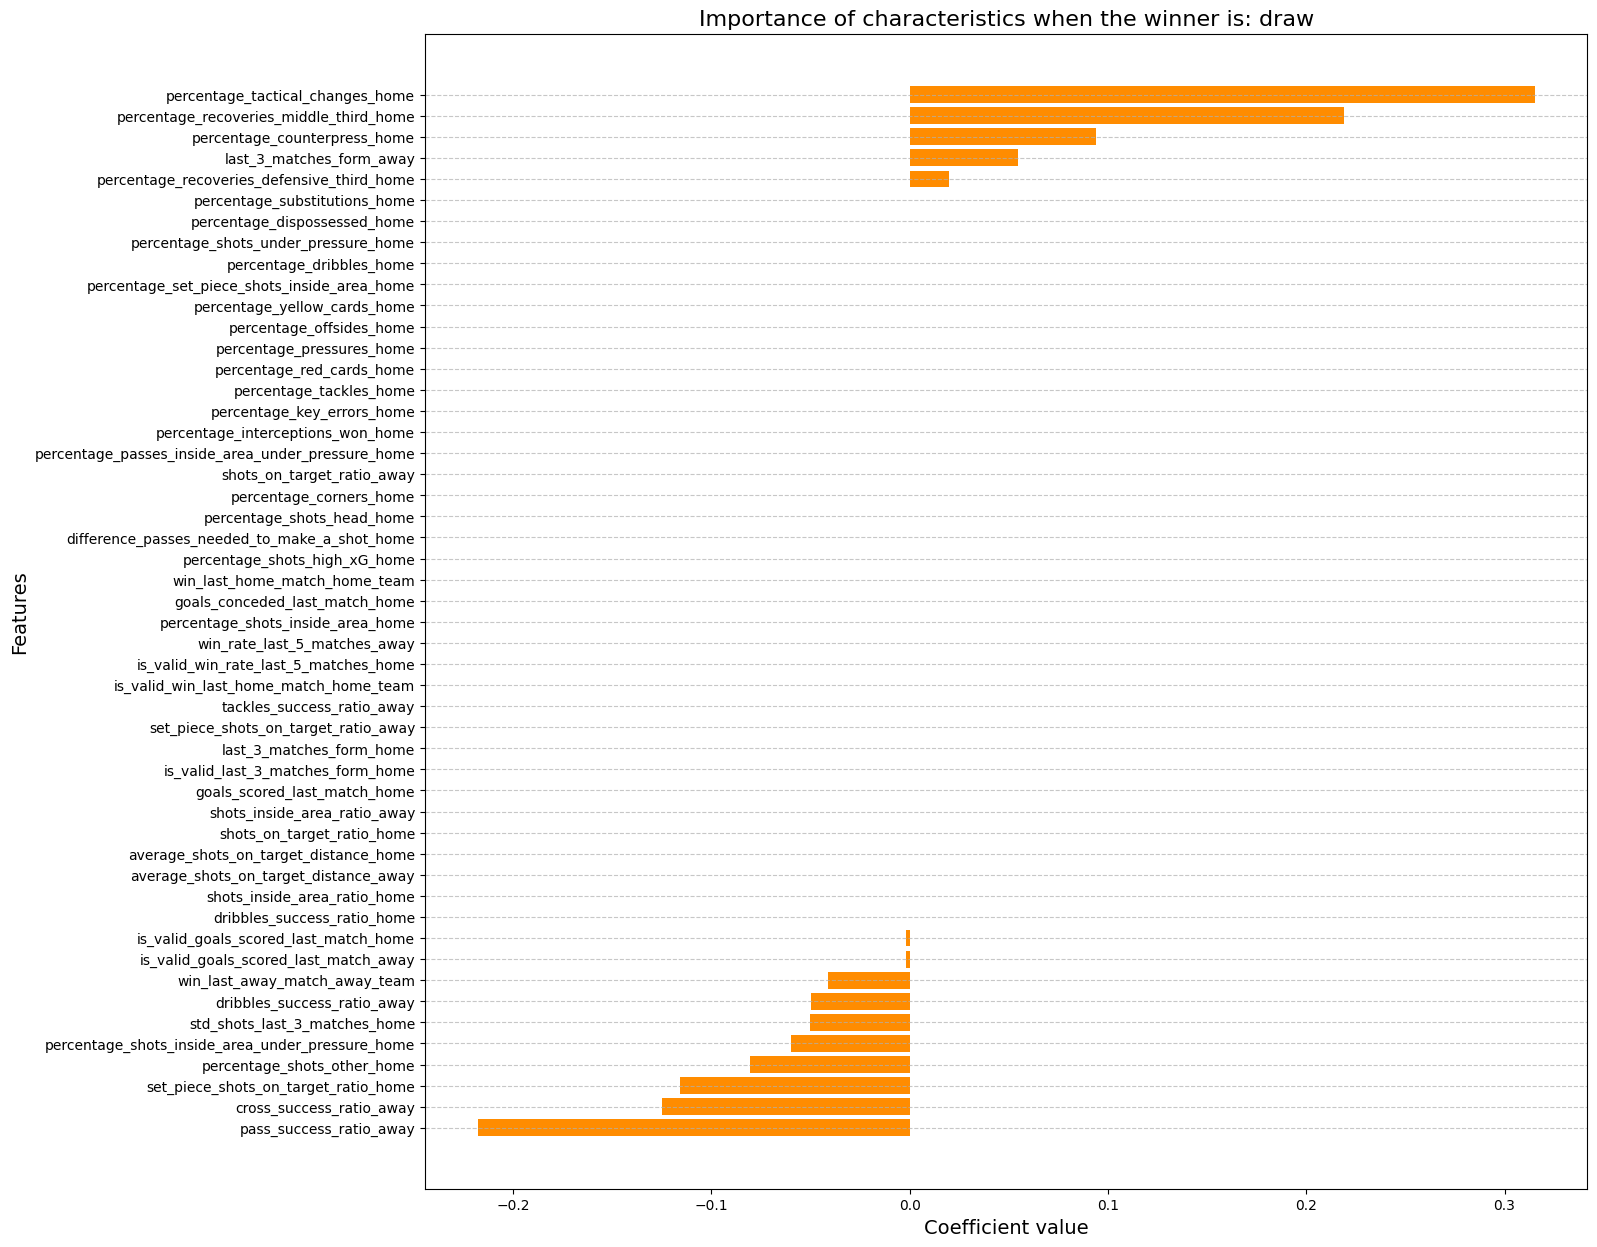

Clase 2: ['home_team']


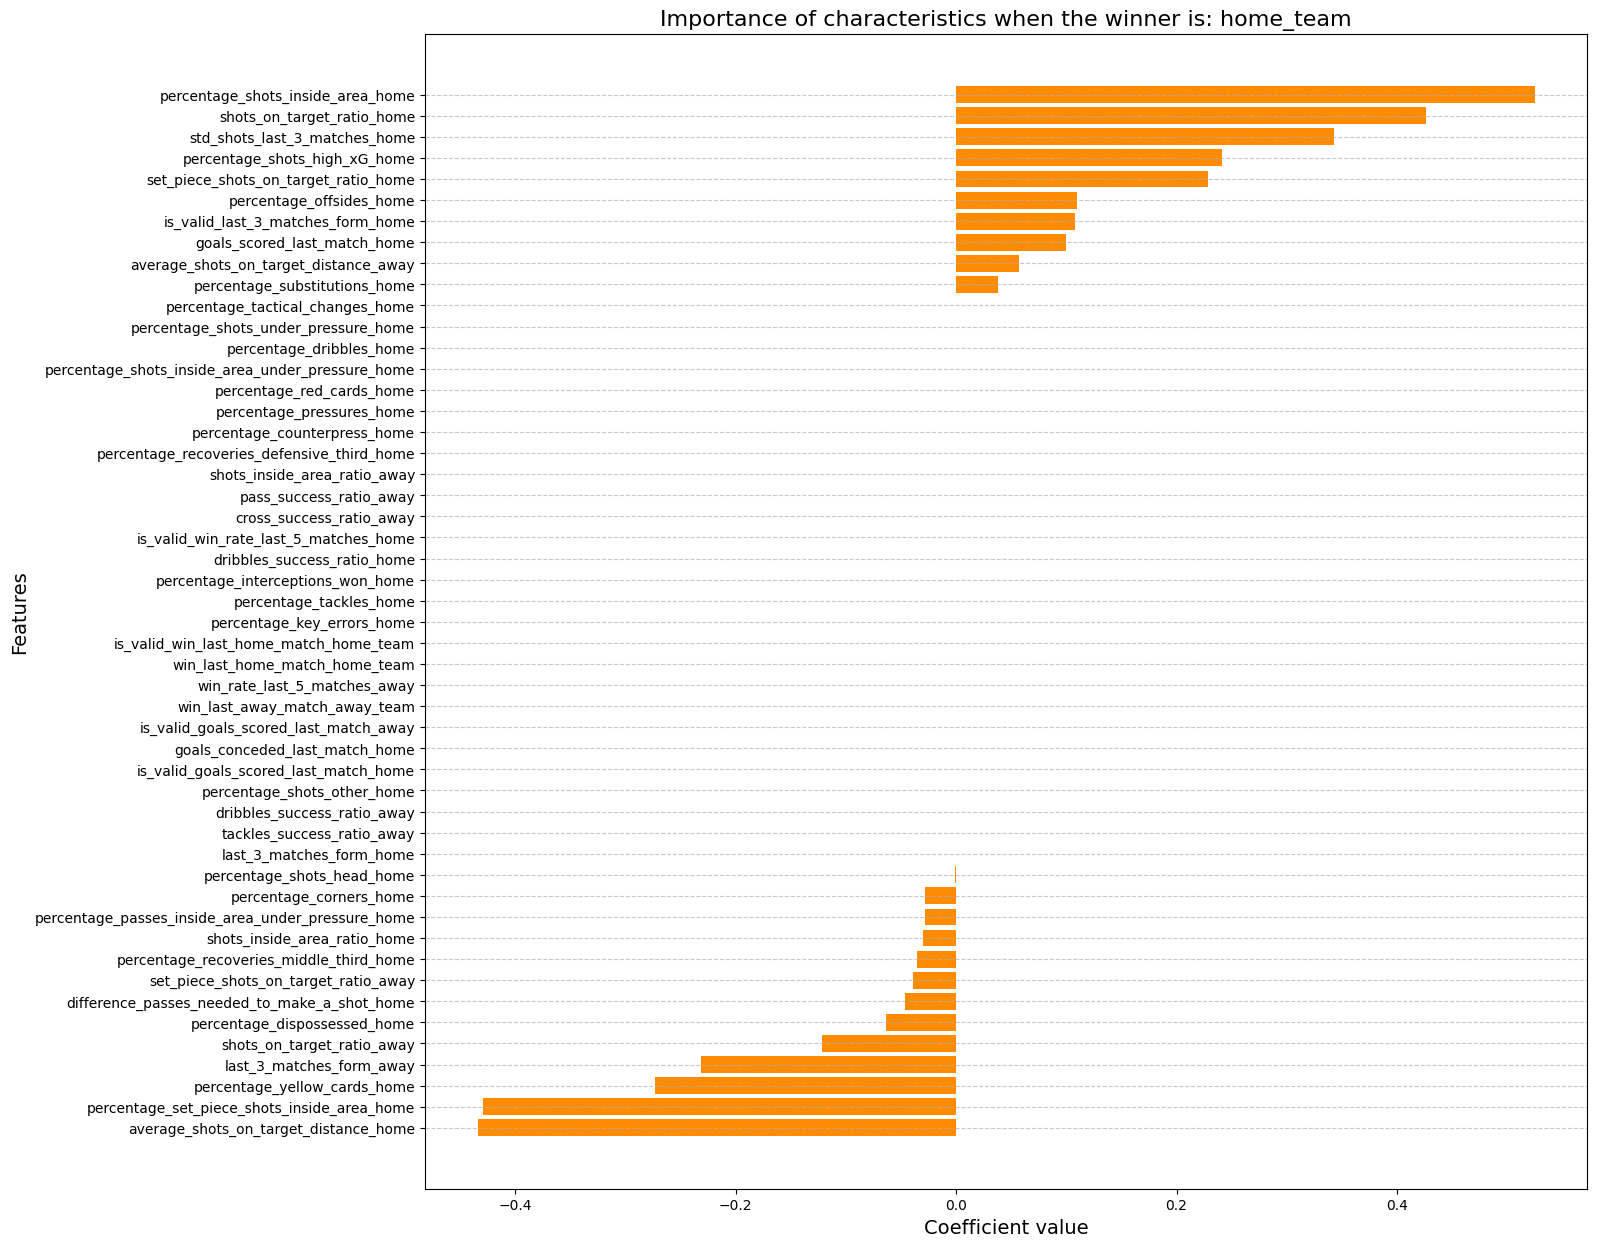

In [5]:
from src.analysis import laliga_global_analysis

laliga_global_analysis(best_model_LaLiga, feature_names_reduced_LaLiga, encoder_LaLiga)

Vamos a analizar cada uno de estos gráficos:

- **Importancia de características para la victoria del equipo visitante (*away_team*)**: Las características en este gráfico aumentan la probabilidad de que el equipo visitante gane el partido.
    - **Características que favorecen la victoria del equipo visitante**: 📈
        - `difference_passes_needed_to_make_a_shot_home`: Si el equipo local necesita más pases para generar un tiro, su ataque es menos eficiente, lo que favorece al visitante.
        - `shots_on_target_ratio_away`: Un equipo visitante con un alto porcentaje de tiros a puerta tiene más probabilidades de marcar y ganar.
        - `percentage_shots_head_home`: Al aumentar estos porcentajes puede significar que el equipo local no esta encontrando otro recurso que no sea el juego aéreo para atacar al equipo visitante debido a que consiguen defender bien.
        - `percentage_red_cards_home`: Si aumenta significa que el equipo local ha perdido algún jugador lo cual hace que este en inferioridad y que tengan que cambiar los planes lo cual favorece al equipo visitante.
        - `percentage_key_errors_home`: Más errores clave del equipo local que el equipo visitante que pueden ser aprovechados por el visitante.
        - `percentage_corners_home`: El equipo local esta fallando más lo cual esta derivando en que las jugadas acaben en más corners que en goles.
        - `win_last_away_match_away_team`: También influye que el equipo visitante ganase su último partido como visitante ya que esto puede indicar una dinámica positiva.
        - `percentage_shots_under_pressure_home`: Entre más tiros haya hecho con presión el equipo local que el visitante, más probabilidades tendrá de no meter gol el equipo local.
        - `shots_inside_area_ratio_away`: Entre mayor sea el ratio de tiros dentro del área del equipo visitante respecto a sus tiros en el partido, mayor probabilidad tiene de marcar gol ya que el tiro será más peligroso.
        - `cross_sucess_ratio_away`, `passes_success_ratio_away`: Entre mayor sean estos ratios, mayor acierto se ha tenido en la circulación del balón por el equipo visitante lo cual le favorece.
        - `percentage_passes_inside_area_under_pressure_home`: Entre mayor sea el porcentaje, significa que el equipo visitante presiona más los pases en el área que el equipo local lo cual influye en que no puedan jugar de manera cómoda cerca de la portería rival y tengan menos facilidad de meter gol los rivales (locales).
    - **Características que no favorecen la victoria del equipo visitante**: 📉
        - `percentage_shots_high_xG_home`, `shots_on_target_ratio_home`: Si el equipo local tiene muchos tiros con un alto porcentaje de gol o un alto porcentaje de tiros a puerta, genera más peligro, por lo que esta característica tiene un coeficiente negativo en la victoria del visitante.
        - `percentage_offsides_home`: Si el equipo local ha caido más veces en fuera de juego puede significar que están atacando más lo que puede implicar que mantengan más tiempo la pelota y que estén constantemente buscando la espalda del equipo visitante.
        - `percentage_tackles_home`: significa que el equipo local hace más tackles que el equipo visitante lo cual puede influir negativamente sobre el equipo visitante ya que puede llevar a más recuperaciones por parte del equipo local o puede llevar a que cortan jugadas prometedoras del equipo visitante.
        - `goals_scored_last_match_home`: Si el equipo local viene de marcar una gran cantidad de goles esto puede influir en que el equipo local vengan motivados y en un buen estado de forma lo cual influye negativamente en el equipo visitante.
        - `dribbles_sucess_ratio_home`: Entre mayor sea el ratio de regates completados por el equipo local, mayor capacidad para superar a jugadores del equipo visitante han tenido lo cual puede implicar situaciones peligrosas en el juego a favor del equipo visitante.
    - **Características que no tienen importancia en la victoria del equipo visitante**:
        - `last_3_matches_form_home`, `last_3_matches_form_away`: Parece ser que la forma de los últimos partidos de los dos equipos no influye en una posible victoria del equipo visitante.
        - `percentage_yellow_cards_home`: El porcentaje de tarjetas amarillas del equipo local respecto al total del partido no influye en la victoria del equipo visitante.
        - `percentage_shots_inside_area_home`: La cantidad de tiros dentro del área del equipo local respecto al total del partido (local+visitante) no influye en la victoria del equipo visitante.
        - `percentage_recoveries_defensive_third_home`, `percentage_recoveries_middle_third_home`: La cantidad de recuperaciones del equipo local en el cualquier tercio del campo respecto al total del partido no influye en la victoria del equipo visitante.
        - `average_shots_on_target_distance_away`: La distancia media de donde se hagan los tiros a puerta del equipo visitante no influye en la victoria del equipo visitante.
        - `percentage_pressures_home`: La cantidad de presiones del equipo local respecto al total no influye en la victoria del equipo visitante.
        - `percentage_shots_inside_area_under_pressure_home`, `percentage_dribbles_home`... son algunas de las demás características que no influyen en la victoria del equipo visitante.
    - **Conclusión**: Para que un equipo visitante tenga una mayor probabilidad de ganar, necesita ser eficiente en ataque, aprovechar los errores y dificultades del equipo local, y contar con una dinámica positiva previa en partidos fuera de casa. Sin embargo, si el equipo local logra generar peligro con tiros de calidad, una defensa sólida y un juego ofensivo activo, la victoria del visitante se vuelve menos probable. Algunos factores que no son infuyentes son: la dinámica general que se lleve en varios partidos atrás (sin embargo, partidos justo anteriores sí), recuperaciones en cualquier tercio del campo, tarjetas amarillas...

- **Importancia de características para el empate (*draw*)**: El empate en un partido suele estar influenciado por un equilibrio en las métricas de ataque y defensa de ambos equipos. Algunas observaciones clave:
    - **Características que favorecen el empate**: 📈
        - `percentage_tactical_changes_home`: Si el equipo local realiza más cambios tácticos durante el partido puede estar ajustando su estrategia constantemente, lo que puede evitar que el equipo visitante imponga su dominio y llevar el partido a un empate.
        - `percentage_recoveries_middle_third_home`: Un alto porcentaje de recuperaciones en el tercio medio por el equipo local indica un partido trabado en el centro del campo, con dificultades para que alguno de los equipos genere oportunidades claras.
        - `percentage_counterpress_home`: Una alta presión tras pérdida por parte del equipo local impide que el equipo rival lance ataques rápidos, manteniendo el juego más equilibrado.
        - `last_3_matches_form_away`: Si el equipo visitante ha tenido un buen rendimiento en los últimos tres partidos, puede ser menos propenso a perder a pesar de jugar fuera, aumentando la probabilidad de un empate.
        - `percentage_recoveries_defensive_third_home`: Si el equipo local recupera muchos balones en su tercio defensivo, evita que el equipo visitante genere muchas ocasiones de gol, lo que favorece un partido con pocos goles y, por ende, un empate.
    - **Características que no favorecen el empate**: 📉
        - `cross_success_ratio_away`, `pass_success_ratio_away`: Si el equipo visitante tiene un alto porcentaje de acierto en pases y centros, es más probable que genere situaciones de peligro y pueda romper el empate con un gol.
        - `set_piece_shots_on_target_ratio_home`: Un equipo local que tiene un alto porcentaje de tiros a puerta desde jugadas a balón parado puede aprovechar estas situaciones para ganar el partido.
        - `dribbles_success_ratio_away`: Si el equipo visitante tiene un alto ratio de regates significa que en varios momneto ha podido estar en superioridad y de esta manera tener más ocasiones para ganar el partido.
        - `win_last_away_match_away_team`: Si el equipo visitante ha ganado su último partido fuera de casa puede significar que viene en una buena dinámica fuera de casa y que puede ganar el partido y romper el empate.
        - `std_shots_last_3_matches_home`: Significa que el equipo local mantiene un número de tiros bastante constante en los partidos lo que puede signficar que si está en una mala dinámica tira muy poco y puede perder el partido o si está en una buena dinámica tira mucho y puede ganar el partido rompiendo así el empate.
    - **Características que no tienen importancia en el empate**:
        - `win_rate_last_5_matches_away`: La tasa de victorias del equipo visitante en los últimos cinco partidos no parece ser un factor determinante para el empate.
        - `percentage_tackles_home`: La cantidad de entradas realizadas por los equipos no tiene una relación clara con la probabilidad de empate.
        - `percentage_interceptions_won_home`: A pesar de ser una métrica defensiva importante, no tiene un impacto significativo en el resultado final del partido.
        - `percentage_shots_inside_area_under_pressure_home`: A pesar de indicar situaciones de presión en el área, no parece afectar la probabilidad de empate.
        - `difference_passes_needed_to_make_a_shot_home`, `percentage_shots_high_xG_home`, `shots_on_target_ratio_home`, `goals_scored_last_match_home`, `goals_conceded_last_match_home`, `percentage_red_cards_home`, `percentage_yellow_cards_home`... son algunas de las métrica que no tienen importancia a la hora de predecir un empate.
    - **Conclusión**: Un empate suele ser el resultado de un partido equilibrado donde ninguno de los equipos logra imponerse claramente. Factores como la gestión táctica, las recuperaciones en el medio campo, la solidez defensiva y la estabilidad en el rendimiento reciente pueden favorecer un empate. Por otro lado, si uno de los equipos demuestra una alta efectividad en ataque, mayor precisión en pases y centros, o un dominio en jugadas a balón parado, la probabilidad de empate disminuye. Finalmente, ciertos aspectos como el rendimiento en partidos anteriores o métricas defensivas específicas no parecen influir directamente en la probabilidad de que el partido termine en empate.

- **Importancia de características para la victoria del equipo local (*home_team*)**: Las características en este gráfico aumentan la probabilidad de que el equipo visitante gane el partido.
    - **Características que favorecen la victoria del equipo local**: 📈
        - `percentage_shots_inside_area_home`: Un mayor porcentaje de tiros dentro del área indica que el equipo local está generando oportunidades claras de gol.
        - `shots_on_target_ratio_home`: Un equipo local con un alto porcentaje de tiros a puerta tiene más probabilidades de marcar goles.
        - `std_shots_last_3_matches_home`: Una menor variabilidad en los tiros en los últimos tres partidos puede indicar que el equipo local mantiene una producción ofensiva constante.
        - `percentage_shots_high_xG_home`: Un equipo local que logra disparos con un alto xG (expectativa de gol) genera más ocasiones peligrosas.
        - `set_piece_shots_on_target_ratio_home`: Indica que el equipo local aprovecha mejor sus oportunidades a balón parado.
        - `percentage_offsides_home`: Si el equipo local cae en fuera de juego con frecuencia, indica una estrategia ofensiva agresiva y un dominio del ataque.
        - `goals_scored_last_match_home`: Si el equipo local ha metido muchos goles en el partido pasado puede reflejar que esta muy acertado de cara a puerta.
        - `average_shots_on_target_distance_away`: Si lo tiros que hace a puerta el equipo visitante son, de media, desde una distancia lejana puede indicar que no tienen otra forma de tratar de meter gol, señalando un buen trabajo defensivo del equipo local y de esta manera dejando que se creen ocasiones claras de gol por el equipo visitante.
        - `percentage_substitutions_home`: Un mayor número de sustituciones puede reflejar una gestión táctica efectiva para mantener el ritmo del partido.
    - **Características que no favorecen la victoria del equipo local**: 📉
        - `average_shots_on_target_distance_away`: Si los tiros que hace el equipo local de media tienen una distancia lejana tendrán más complicado meter gol ya que generarán menos peligro.
        - `percentage_yellow_cards_home`: Un alto número de tarjetas amarillas podría reflejar un juego más agresivo, lo que puede generar faltas innecesarias y conceder oportunidades al rival por parte del equipo local.
        - `shots_on_target_ratio_away`: Un equipo visitante con un alto porcentaje de tiros a puerta puede generar ocasiones de peligro y complicar la victoria del local.
        - `last_3_matches_form_away`: Un equipo visitante que venga en buena forma puede complicar la victoria por parte del equipo local.
        - `difference_passes_needed_to_make_a_shot_home`: Si el equipo local necesita más pases para generar un tiro, su ataque es menos eficiente, lo que favorece al visitante.
        - `percentage_corners_home`: Si el equipo local tiene más corners que el equipo visitante esto puede significar que no están acertando en sus ataques mientras que el equipo visitante si.
        - `percentage_dispossessed_home`: Si el equipo local pierde más el balón que el visitante eso puede significar que no son capaces de llevar el control del partido y de poder generar ocasiones de peligro.
    - **Características que no tienen importancia en la victoria del equipo local**:
        - `win_rate_last_5_matches_away`: La tasa de victorias del equipo visitante en los últimos cinco partidos no parece afectar directamente la victoria del equipo local.
        - `percentage_pressures_home`, `percentage_counterpress_home`, `percentage_interceptions_won_home`, `percentage_tackles_home`: A pesar de ser métricas defensivas relevantes, no tiene un impacto significativo en el resultado final.
        - `percentage_shots_inside_area_ratio_away`: El porcentaje de tiros dentro del área del equipo visitante no parece afectar directamente la victoria del equipo local.
        - `dribbles_success_ratio_home`, `percentage_key_errors_home`, `percentage_yellow_cards_home`, `percentage_red_cards_home`... son otras de las métricas que no influyen.
    - **Conclusión**: La victoria del equipo local se basa en una combinación de eficiencia ofensiva, control del juego y solidez defensiva. Un equipo local con alta efectividad en tiros, generación de peligro dentro del área y capacidad de adaptación táctica tiene más probabilidades de ganar. Además, una defensa fuerte y una recuperación rápida del balón ayudan a reducir las oportunidades del rival. Sin embargo, si el equipo visitante es eficiente en ataque y genera peligro con tiros a puerta, la probabilidad de victoria local disminuye. Finalmente, algunos factores como la forma en los últimos partidos o ciertas métricas defensivas no parecen influir directamente en la victoria del equipo local.

- **Conclusiones generales**: 
    - El equipo visitante gana cuando es efectivo en ataque, el equipo local falla en sus oportunidades, y la presión del visitante limita el juego ofensivo del local.
    - El empate ocurre en partidos donde ninguno de los dos equipos logra imponerse, con un juego equilibrado en el medio campo, recuperaciones constantes y pocos errores defensivos.
    - El equipo local gana cuando genera muchas oportunidades claras de gol, mantiene un control efectivo del partido, y el visitante no logra responder con eficiencia en ataque.

Ahora comenzamos el análisis de explicabilidad utilizando SHAP. 

El análisis SHAP (SHapley Additive exPlanations) nos permite interpretar el impacto de cada característica en la predicción del modelo. A diferencia de los coeficientes lineales, SHAP captura interacciones entre variables y muestra el impacto individual de cada una en cada predicción. En este documento analizaremos los resultados obtenidos para la predicción de los partidos de La Liga.

Cada uno de los siguientes gráficos representa la importancia de las variables en la predicción de cada posible resultado:
- Victoria del equipo visitante (away_team).
- Empate (draw).
- Victoria del equipo local (home_team).

**Interpretación de los gráficos SHAP**: Cada punto en el gráfico representa un partido. Los valores en el eje X indican el impacto de una característica específica en la predicción del modelo:
- Valores positivos: Incrementan la probabilidad de que el partido termine con el resultado indicado.
- Valores negativos: Disminuyen la probabilidad del resultado.
- Color: Representa el valor de la característica. Rojo indica valores altos y azul valores bajos.

In [6]:
explainer_LaLiga = shap.Explainer(best_model_LaLiga.predict_proba, X_train_reduced_LaLiga, feature_names=feature_names_reduced_LaLiga)
shap_values_LaLiga = explainer_LaLiga(X_test_reduced_LaLiga)

Clase 0: ['away_team']
Características importantes (32):
['shots_on_target_ratio_home', 'shots_on_target_ratio_away', 'average_shots_on_target_distance_home', 'shots_inside_area_ratio_away', 'pass_success_ratio_away', 'cross_success_ratio_away', 'set_piece_shots_on_target_ratio_home', 'set_piece_shots_on_target_ratio_away', 'last_3_matches_form_away', 'is_valid_win_rate_last_5_matches_home', 'win_last_away_match_away_team', 'goals_scored_last_match_home', 'is_valid_goals_scored_last_match_home', 'is_valid_goals_scored_last_match_away', 'std_shots_last_3_matches_home', 'percentage_shots_high_xG_home', 'percentage_shots_inside_area_home', 'percentage_shots_head_home', 'percentage_shots_other_home', 'difference_passes_needed_to_make_a_shot_home', 'percentage_corners_home', 'percentage_tackles_home', 'percentage_key_errors_home', 'percentage_yellow_cards_home', 'percentage_red_cards_home', 'percentage_counterpress_home', 'percentage_offsides_home', 'percentage_recoveries_middle_third_home'

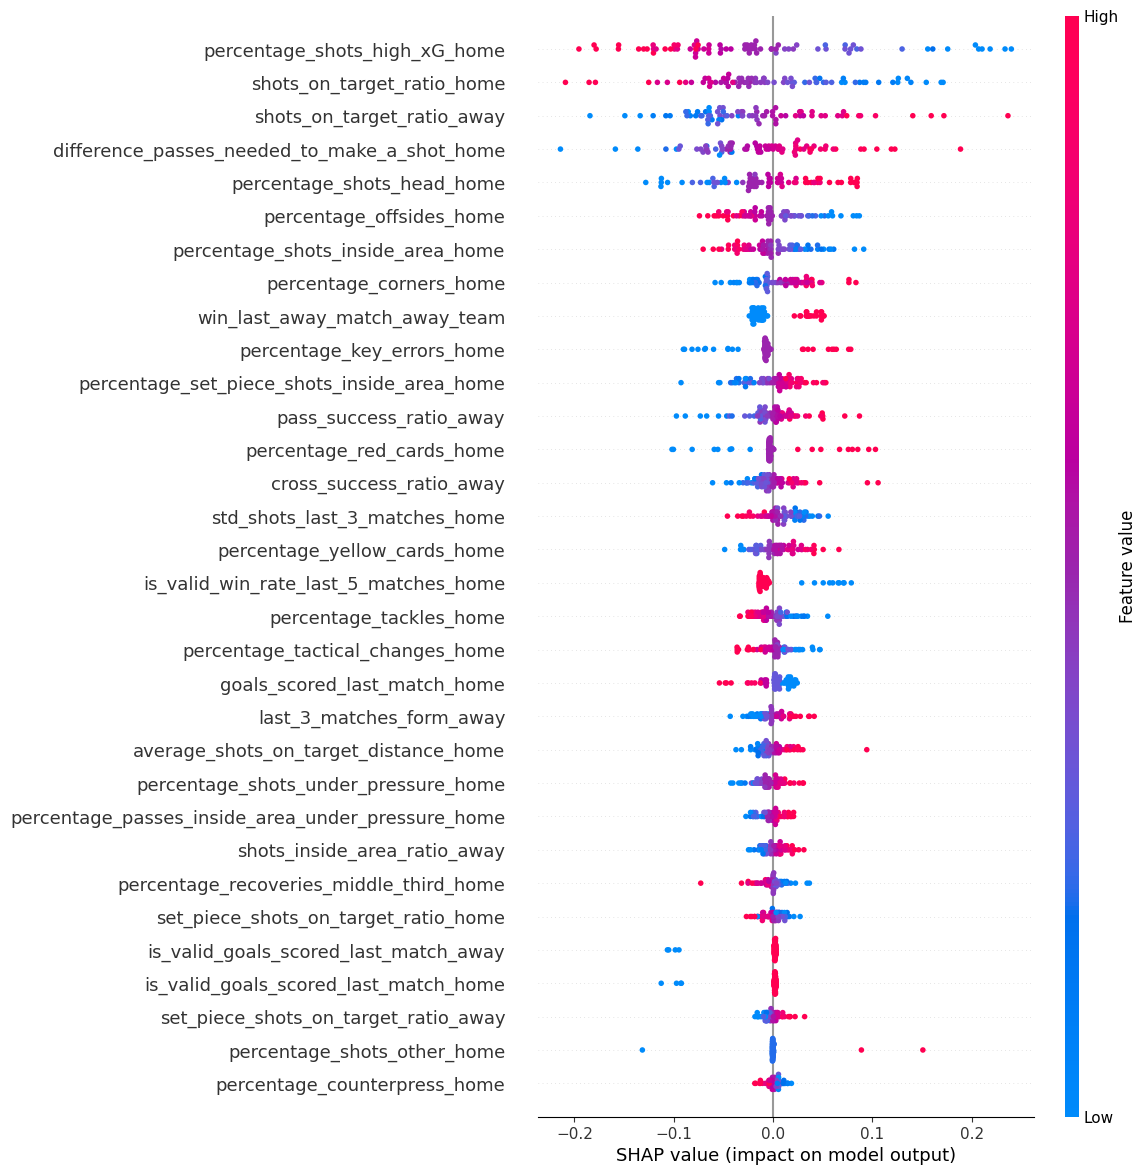

Clase 1: ['draw']
Características importantes (29):
['shots_on_target_ratio_home', 'shots_on_target_ratio_away', 'average_shots_on_target_distance_home', 'pass_success_ratio_away', 'cross_success_ratio_away', 'dribbles_success_ratio_away', 'set_piece_shots_on_target_ratio_home', 'is_valid_last_3_matches_form_home', 'last_3_matches_form_away', 'is_valid_win_rate_last_5_matches_home', 'win_last_away_match_away_team', 'goals_scored_last_match_home', 'std_shots_last_3_matches_home', 'percentage_shots_high_xG_home', 'percentage_shots_inside_area_home', 'percentage_shots_head_home', 'difference_passes_needed_to_make_a_shot_home', 'percentage_corners_home', 'percentage_tackles_home', 'percentage_key_errors_home', 'percentage_yellow_cards_home', 'percentage_red_cards_home', 'percentage_counterpress_home', 'percentage_offsides_home', 'percentage_recoveries_middle_third_home', 'percentage_shots_under_pressure_home', 'percentage_shots_inside_area_under_pressure_home', 'percentage_set_piece_shots_

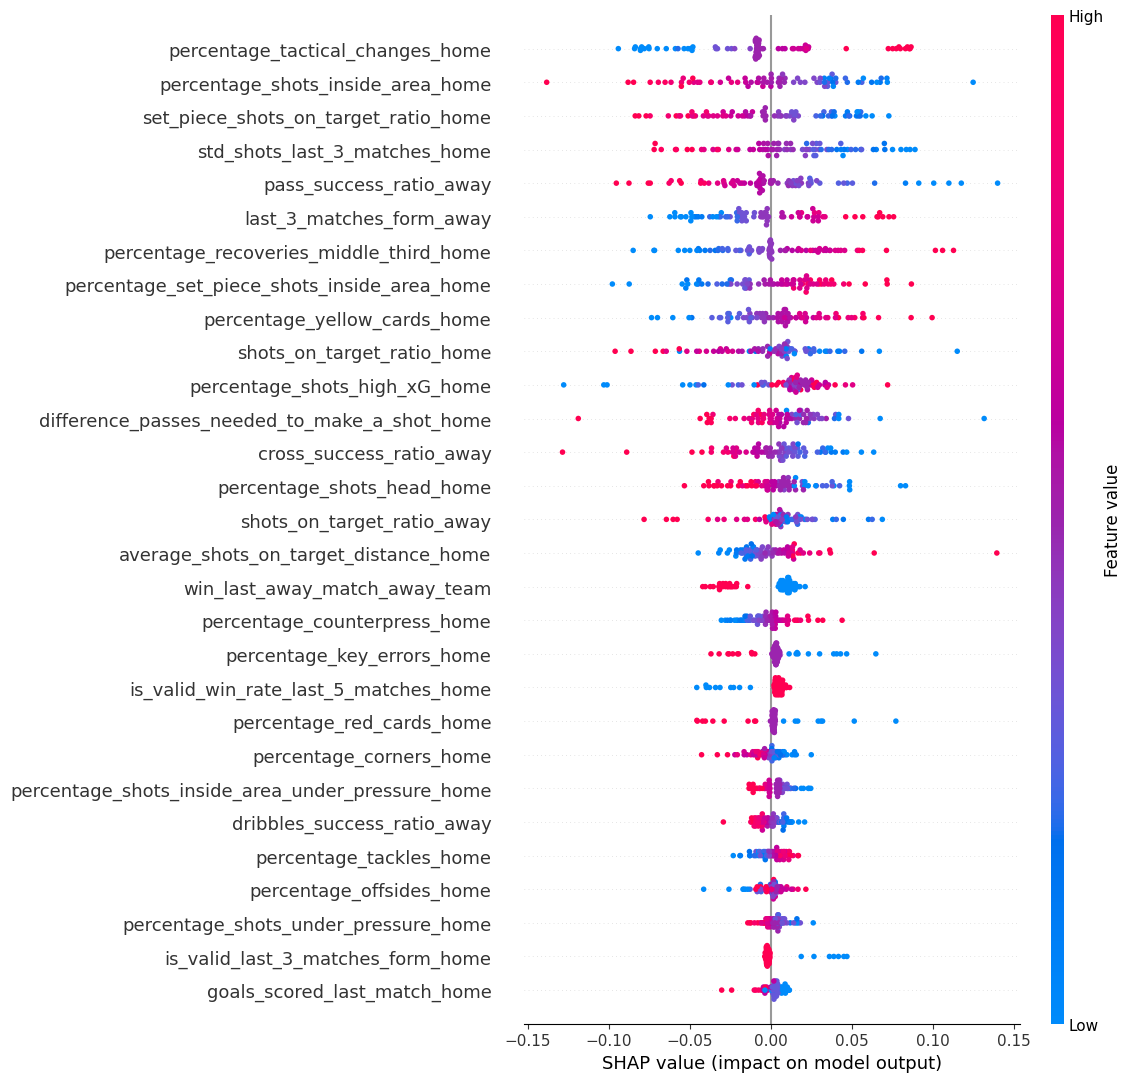

Clase 2: ['home_team']
Características importantes (29):
['shots_on_target_ratio_home', 'shots_on_target_ratio_away', 'average_shots_on_target_distance_home', 'pass_success_ratio_away', 'set_piece_shots_on_target_ratio_home', 'set_piece_shots_on_target_ratio_away', 'is_valid_last_3_matches_form_home', 'last_3_matches_form_away', 'is_valid_win_rate_last_5_matches_home', 'win_last_away_match_away_team', 'goals_scored_last_match_home', 'std_shots_last_3_matches_home', 'percentage_shots_high_xG_home', 'percentage_shots_inside_area_home', 'percentage_shots_head_home', 'difference_passes_needed_to_make_a_shot_home', 'percentage_corners_home', 'percentage_tackles_home', 'percentage_key_errors_home', 'percentage_yellow_cards_home', 'percentage_red_cards_home', 'percentage_counterpress_home', 'percentage_offsides_home', 'percentage_dispossessed_home', 'percentage_recoveries_middle_third_home', 'percentage_shots_under_pressure_home', 'percentage_passes_inside_area_under_pressure_home', 'percenta

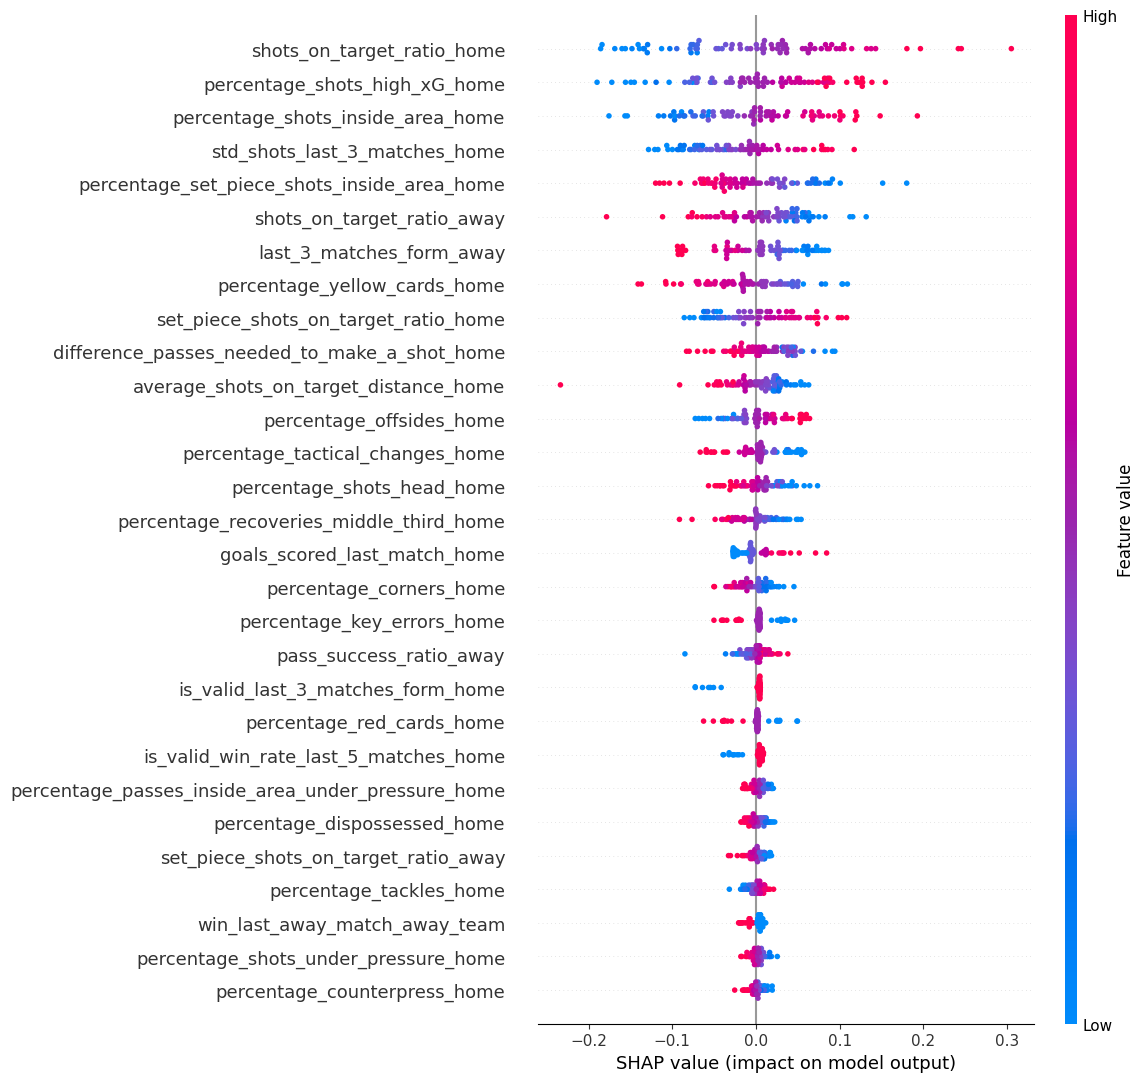

In [7]:
# definimos un umbral de importancia
threshold = 0.005

for i in range(shap_values_LaLiga.shape[2]):
    print(f"Clase {i}: {encoder_LaLiga.inverse_transform([i])}")
    # calculamos la importancia media de cada característica y filtramos las características que superen el umbral
    shap_importance = np.abs(shap_values_LaLiga.values[:, :, i]).mean(axis=0)
    important_features = np.where(shap_importance > threshold)[0]
    unimportant_features = np.where(shap_importance <= threshold)[0]
    print(f"Características importantes ({len(important_features)}):")
    print([feature_names_reduced_LaLiga[idx] for idx in important_features])
    print(f"Características SIN impacto ({len(unimportant_features)}):")
    print([feature_names_reduced_LaLiga[idx] for idx in unimportant_features])
    # si hay características que superen el umbral, mostramos el gráfico
    if len(important_features) > 0:
        shap.plots.beeswarm(shap_values_LaLiga[:, important_features, i], max_display=important_features.size)
    else:
        print(f"No hay características con impacto mayor a {threshold} para la clase {i}.")

Vamos a analizar cada uno de los gráficos:

- **Victoria del equipo visitante**: Este gráfico muestra las características que favorecen o disminuyen la probabilidad de victoria del equipo visitante.
    - **Características que favorecen la victoria del equipo visitante**: 📈
        - `shots_on_target_ratio_away`: Un equipo visitante con un alto porcentaje de tiros a puerta tiene mayor probabilidad de marcar goles.
        - `difference_passes_needed_to_make_a_shot_home`: Si el equipo local necesita más pases para generar un tiro, su ataque es menos eficiente, favoreciendo al visitante.
        - `percentage_shots_head_home`: Puede indicar que el equipo local no está siendo capaz de hacer daño al rival por el juego y que está intentando hacer centros al área que desenbocan en remates de cabeza que suelen llevar menos peligro.
        - `percentage_corners_home`: Si el equipo local tiene un bajo porcentaje de corners en el partido significa que esta sabiendo materializar sus ocasiones mientras que el equipo visitante no.
        - `percentage_key_errors_home`: Más errores clave del equipo local pueden ser aprovechados por el visitante. Aunque, según el gráfico, no suele darse en muchos partidos.
        - `win_last_away_match_away_team`: Si el equipo visitante ganó su último partido fuera de casa, puede indicar una dinámica positiva.
        - `percentage_red_cards_home`, `percentage_yellow_cards_home`: Si el equipo local recibe más tarjetas amarillas o tarjetas rojas, además de quedarse con un hombre menos, tiene que cambiar de plan y también podría deberse a la frustración de uno de los jugadores del equipo local.
        - `percentage_shots_under_pressure_home`: Un equipo local que dispara bajo presión es menos eficiente en ataque.
        - `cross_success_ratio_away`, `pass_success_ratio_away`: Un equipo visitante con alta precisión en centros y pases genera más oportunidades de gol.
        - `last_3_matches_form_away`: Si el equipo visitante viene de obtener buenos resultados en sus últimos tres partidos puede significar que viene en una buena dinámica y que puede llevarse también el partido que nos ocupa.
        - `average_shots_on_target_distance_home`: Si los tiros que el equipo local hace a puerta son desde una distancia lejana de media, signfica que está creando menos peligro que si los hiciera desde una distancia más cercana. También puede significar que el equipo visitante esta defendiendo bien y que el equipo local está probando suerte con tiros lejanos que no llevan todo el peligro que les gustaría.
        - `shots_inside_area_ratio_away`: Si de los tiros del equipo visitante un alto porcentaje son desde dentro del área se genera mucho más peligro que si fuese desde fuera del área.
        - `set_piece_shots_on_target_ratio_away`: Si de los tiros que hace a balón parado el equipo local, un alto porcentaje van a puerta se genera mucho más peligro.
        - `std_shots_last_3_macthes_home`: A medida que la variabilidad de los tiros del equipo local aumenta, el impacto en la victoria visitante también lo hace. Esto podría indicar que un equipo local inconsistente en ataque (a veces genera muchas oportunidades y otras muy pocas) es más propenso a perder.
    - **Características que no favorecen la victoria del equipo visitante**: 📉
        - `shots_on_target_ratio_home`: Un equipo local con un alto porcentaje de tiros a puerta genera peligro, reduciendo la probabilidad de victoria del visitante.
        - `percentage_shots_high_xG_home`: Si el equipo local logra tiros de alto *expected goals* (métrica que calcula probabilidad de que un tiro sea gol dependiendo de la situación del atacante, la posición de los defensores, localización en el campo, localización del portero, etc.), aumenta sus probabilidades de marcar.
        - `percentage_shots_inside_area_home`: Si el equipo local hace más tiros desde dentro del área que el equipo local, esto significará que el equipo local puede estar generando más peligro que el equipo visitante.
        - `percentage_offsides_home`: Un equipo local que cae en fuera de juego con frecuencia puede estar atacando más.
        - `percentage_tackles_home`: Una alta cantidad de tackles del equipo local puede indicar una defensa fuerte.
        - `goals_scored_last_match_home`: Si el equipo local viene de marcar muchos goles en su último partido puede influir en el ánimo de los jugadores del equipo local e indicar que vienen de estar acertados de cara a gol.
        - `percentage_tactical_changes_home`: Si el equipo local hace varios cambios puede indicar que quieren mantener el ritmo del partido introduciendo jugadores nuevos.
        - `dribbles_sucess_ratio_home`: Aunque, según el gráfico, con menos importancia, que haya un alto ratio de regates exitosos por parte del equipo local puede indicar que están superando la defensa del equipo visitante con facilidad y creando superioridades en ataque que puede desembocar en claras ocasiones de gol.
        - `percentage_recoveries_middle_third_home`: A medida que el equipo local hace más recuperaciones que el equipo visitante, aumenta la probabilidad de que no gane el equipo visitante y esto puede ser debido a que el equipo local esta sabiendo contrarrestar los ataques del equipo visitante y poner lanzar ataques desde esas recuperaciones.
    - **Conclusión**: Para que un equipo visitante tenga una mayor probabilidad de ganar, necesita ser eficiente en ataque, aprovechar los errores del equipo local y tener una racha positiva fuera de casa. Sin embargo, si el equipo local genera muchas ocasiones peligrosas y es fuerte en defensa, la victoria visitante se vuelve menos probable.

- **Empate**: Este gráfico muestra las características que favorecen o disminuyen la probabilidad de empate en un partido. El empate se suele asociar a partidos equilibrados donde ningún equipo impone una gran diferencia en ataque o defensa.
    - **Características que favorecen el empate**: 📈
        - `percentage_tactical_changes_home`: Si el equipo local realiza ajustes tácticos constantes, el partido puede mantenerse equilibrado.
        - `percentage_recoveries_middle_third_home`: Muchas más recuperaciones en el centro del campo por parte del equipo local frente al visitante pueden indicar un partido trabado sin muchas ocasiones claras.
        - `percentage_counterpress_home`: Mayor número de presiones tras pérdida intensa por parte del equipo local frente al visitante puede impedir que el equipo visitante cree ocasiones de gol. Además, el equipo local al jugar frente a su afición debería crecerse y mostrar un mejor juego, si es el equipo visitante quien hace una presión intensa tras pérdida puede signficar que el equipo visitante esta siendo capaz de contrarrestar el juego del equipo local lo cuál puede hacer que el equipo local se hunda.
        - `last_3_matches_form_away`: Si el equipo visitante ha tenido un buen rendimiento en los últimos tres partidos, puede ser menos propenso a perder y al jugar el equipo local frente a su afición también dará la cara al partido lo que puede indicar que el partido va a ser muy igualado.
        - `percentage_recoveries_middle_third_home`: Si el equipo local recupera más balones que el equipo visitante en el tercio medio puede significar que estan siendo capaces de frenar los ataques del equipo visitante.
        - `percentage_yellow_cards_home`: A medida que aumenta el número de tarjetas amarillas a favor del equipo local aumenta la probabilidad de empate y esto puede deberse a que el equipo local puede empezar a verse frustrado por el número de ocasiones que desperdicia en el partido.
    - **Características que no favorecen el empate**: 📉
        - `percentage_shots_inside_area_home`: A medida que aumenta el porcentahe de tiros desde dentro del área del equipo local respecto los tiros en el partido, disminuye la probabilidad de empate y esto se puede deber a que están generando más peligro que el equipo local y que pueden llevarse la victoria.
        - `set_piece_shots_on_target_ratio_home`: Si aumenta el porcentaje de remates a balón parado del equipo local que van a puerta significa que están generando más peligro.
        - `pass_success_ratio_away`, `cross_success_ratio_away`: Un equipo visitante con alta precisión en pases o en centros puede generar ocasiones claras que el equipo local no esta sabiendo contrarrestar y ganar el partido.
        - `dribbles_success_ratio_away`: Un equipo visitante que logra completar muchos regates puede generar situaciones de peligro, reduciendo la probabilidad de empate.
        - `set_piece_shots_on_target_ratio_home`: Un equipo local efectivo en jugadas a balón parado puede marcar y romper el empate.
        - `std_shots_last_3_matches_home`: Si el equipo local no mantiene la producción de tiros a los largo de los partidos anteriores constante puede significar que viene generando ocasiones de manera irregular y que o puede ganar por estar muy acertado o perder por no estar nada acertado, pero no empatar.
        - `win_last_away_match_away_team`: Si el equipo visitante viene de ganar su último partido en casa que suele ser algo complicado, puede significar que viene con una buena dinámica jugando fuera de casa y que podrían llevarse la victoria en el partido.
    - **Conclusión**: Un empate suele ser el resultado de un partido equilibrado donde ninguno de los equipos logra imponerse claramente. Factores como la gestión táctica, las recuperaciones en el medio campo y la solidez defensiva pueden favorecer un empate. Por otro lado, si uno de los equipos demuestra una alta efectividad en ataque, dominio del juego y buenos resultados pasados, la probabilidad de empate disminuye.

- **Victoria del equipo local**: Este gráfico muestra las características que favorecen o disminuyen la probabilidad de victoria del equipo local.
    - **Características que favorecen la victoria del equipo local**: 📈
        - `shots_on_target_ratio_home`: Un bajo porcentaje de tiros a puerta del equipo local disminuye mucho la probabilidad de victoria, mientras que si este porcentaje va creciendo la probabilidad de victoria va aumentando.
        - `percentage_shots_inside_area_home`: Mayor número de tiros dentro del área del equipo local que del visitante, son generalmente más peligrosos y aumentan la probabilidad de marcar.
        - `percentage_shots_high_xG_home`: Indica que el equipo local genera ocasiones de alta calidad.
        - `set_piece_shots_on_target_ratio_home`: Si de las jugadas a balón parado del equipo local, un alto número han ido a puerta puede influir positivamente en la victoria del equipo local.
        - `goals_scored_last_match_home`: Si el equipo local viene de marcar varios goles en su último partido puede mantener una racha positiva.
    - **Características que no favorecen la victoria del equipo local**: 📉
        - `shots_on_target_ratio_away`: Un equipo visitante con buena precisión en tiros puede complicar la victoria local.
        - `percentage_yellow_cards_home`: Un equipo local con muchas tarjetas amarillas puede estar cometiendo errores que beneficien al rival.
        - `last_3_matches_form_away`: Un equipo visitante con buena racha en sus últimos partidos puede poner en peligro la victoria del equipo local.
        - `average_shots_on_target_distance_home`: Si la distancia media de los tiros del equipo local es muy alta, significa que se ha generado poco peligro con los tiros lo que puede influir en que no han sido capaz de hacer daño al equipo visitante.
        - `percentage_tactical_changes_home`: Si el equipo local hace más cambios tácticos que el equipo visitante puede significar que el equipo local no esta sabiendo dar con la tecla en el partido mientras que el equipo visitante si.
        - `percentage_dispossessed_home`: Si el número de pérdidas del equipo local es mayor que la del visitante puede significar que el equipo local está siendo poco preciso con respecto al equipo visitante lo que genera una clara ventaja a favor del equipo local.
        - `win_last_away_match_away_team`: Si el equipo viene de ganar su último partido fuera de casa significa que puede venir jugando bien fuera de su campo lo cual puede disminuir las probabilidades de victoria del equipo visitante.
    - **Conclusión**: La victoria del equipo local se basa en una combinación de eficiencia ofensiva y control del juego. Un equipo local con alta efectividad en tiros, generación de peligro dentro del área y capacidad de adaptación táctica tiene más probabilidades de ganar. Sin embargo, si el equipo visitante es eficiente en ataque y genera peligro con tiros a puerta, la probabilidad de victoria local disminuye.

- **Conclusiones generales**:
    - La victoria del equipo visitante se asocia a una mayor eficiencia ofensiva y dificultades del equipo local en la creación de oportunidades.
    - Los empates ocurren en partidos con equilibrio táctico, muchas recuperaciones en el mediocampo y presión constante.
    - La victoria del equipo local se relaciona con un ataque efectivo, dominio en tiros de alta calidad y creación de oportunidades claras por parte del equipo local.

Vamos a visualizar el impacto de las características más importantes en la predicción del modelo usando gráficos de dependencia SHAP.

Estos gráficos nos permiten analizar:
- Cómo varía la predicción del modelo a medida que cambia el valor de una característica.
- Qué características tienen el mayor impacto en cada resultado posible (victoria local, empate o victoria visitante).
- Cómo interactúan las características entre sí, identificando relaciones no lineales que afectan la predicción.

¿Cómo seleccionamos las características a analizar?: Para cada posible resultado del partido (victoria local, empate o victoria visitante):
1. Calculamos la importancia promedio de cada característica en función de los valores SHAP.
2. Seleccionamos las 10 características más influyentes en la predicción de cada clase.
3. Generamos gráficos de dependencia para ver cómo afectan a la probabilidad de cada resultado.

¿Cómo interpretar los gráficos SHAP?:
- Eje X: Valores de la característica en los datos originales (sin normalizar).
- Eje Y: Valores SHAP (impacto en la predicción del modelo).
- Colores: Representan otra característica que interactúa con la principal (seleccionada automáticamente por SHAP).

¿Qué podemos descubrir con estos gráficos?
- Si una característica tiene un gran impacto positivo en SHAP, significa que aumenta la probabilidad de ese resultado.
- Si una característica tiene un gran impacto negativo en SHAP, significa que disminuye la probabilidad de ese resultado.
- Si los puntos en el gráfico no siguen una línea recta, puede indicar que existe una interacción compleja entre las características.


Graphs for class: away_team



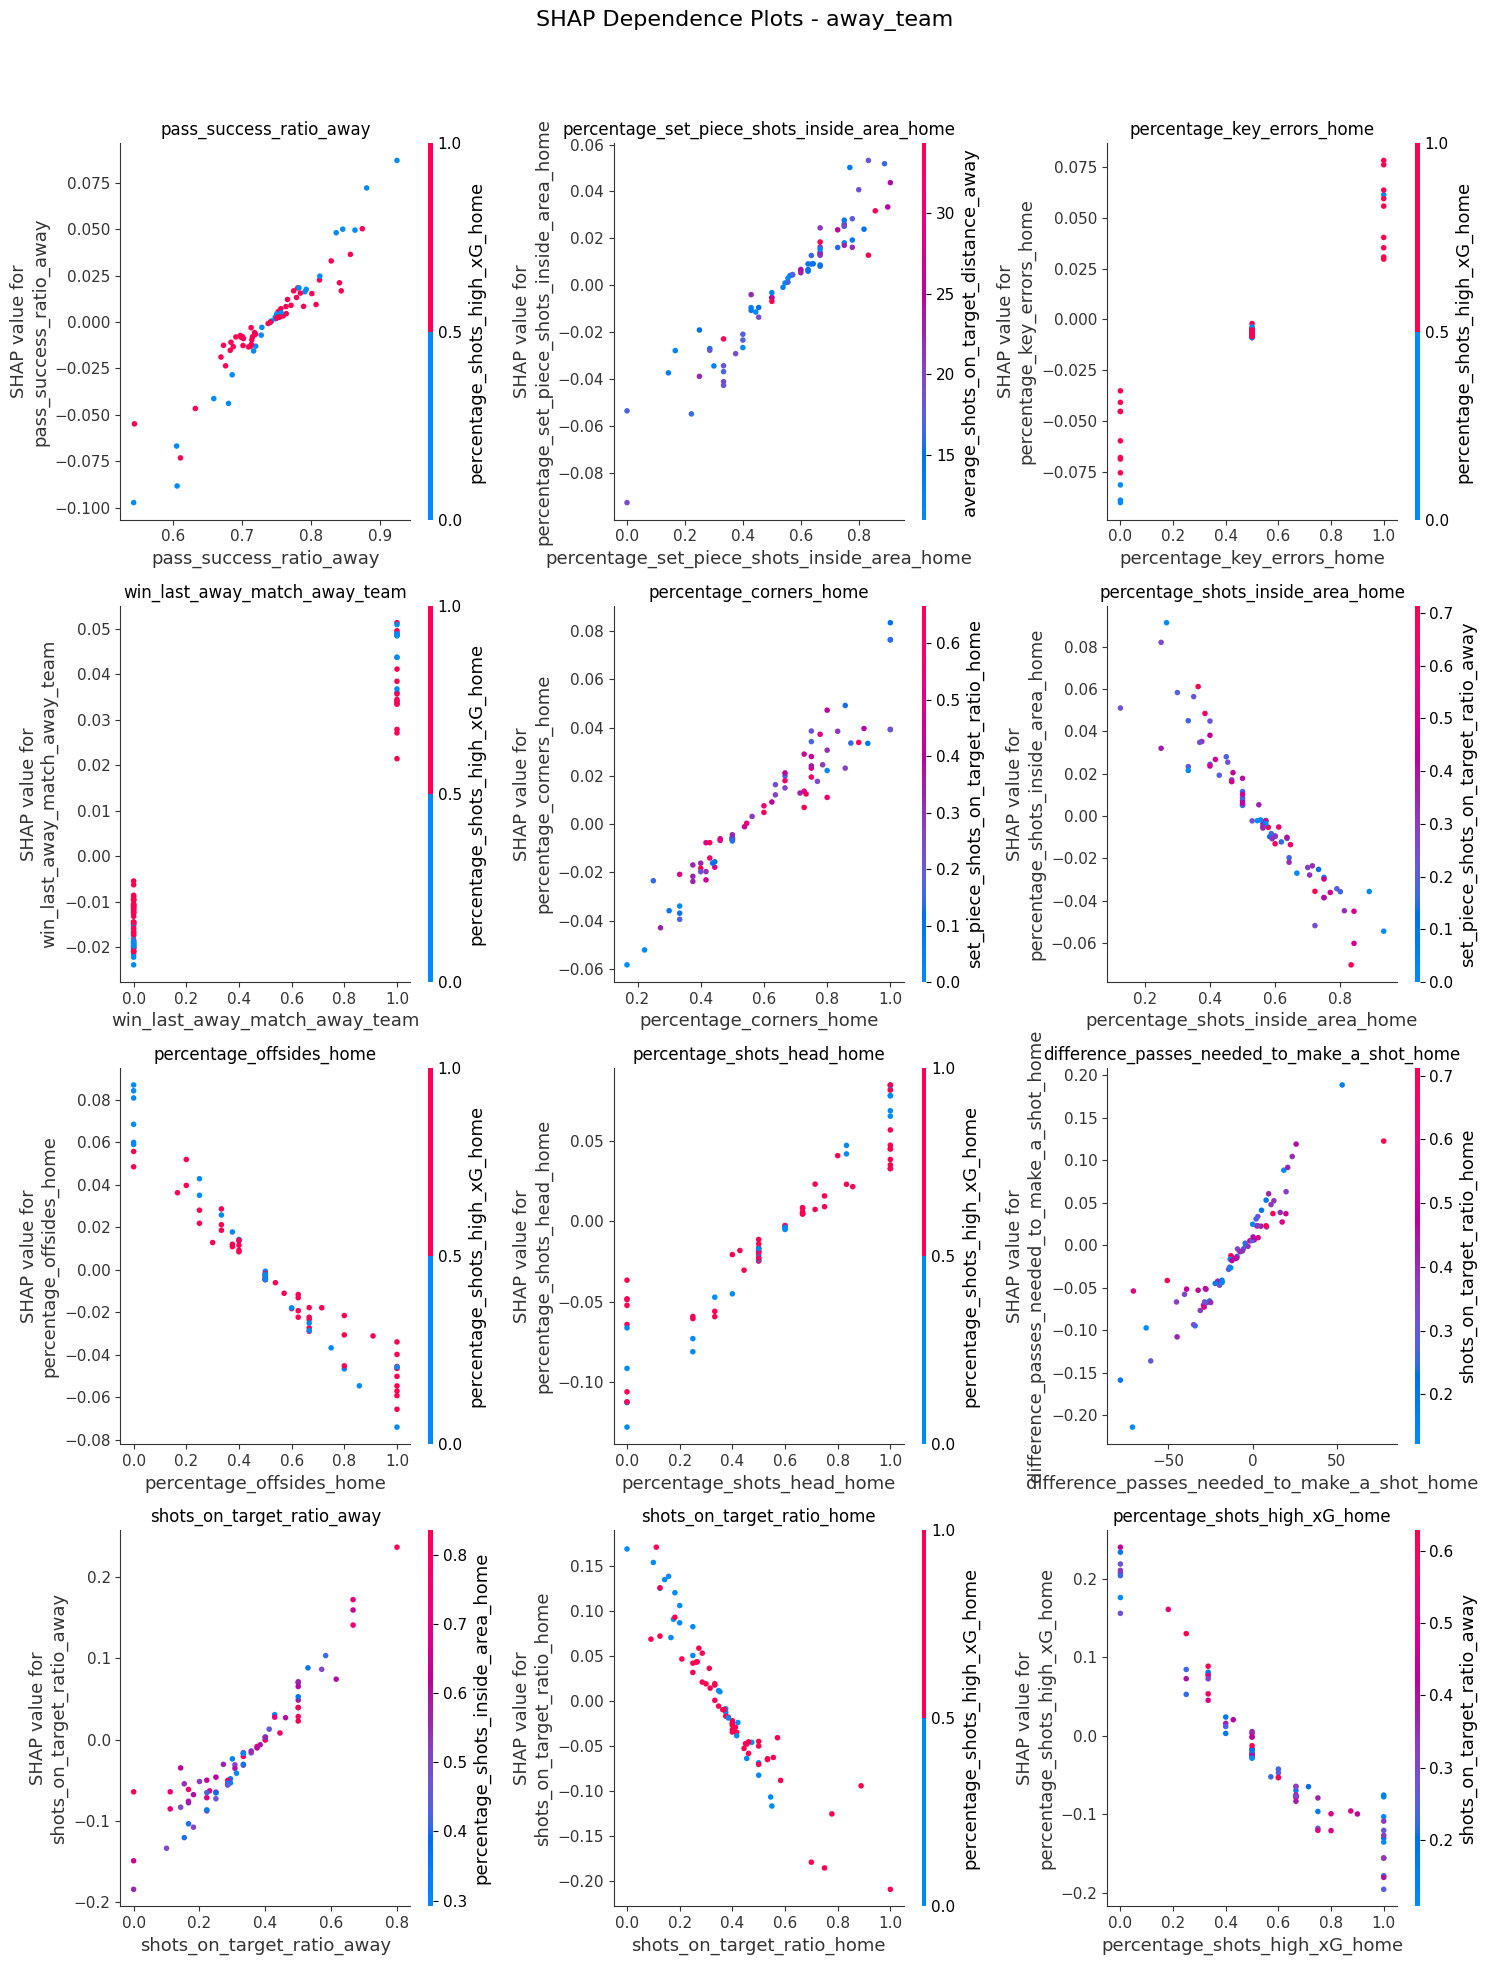


Graphs for class: draw



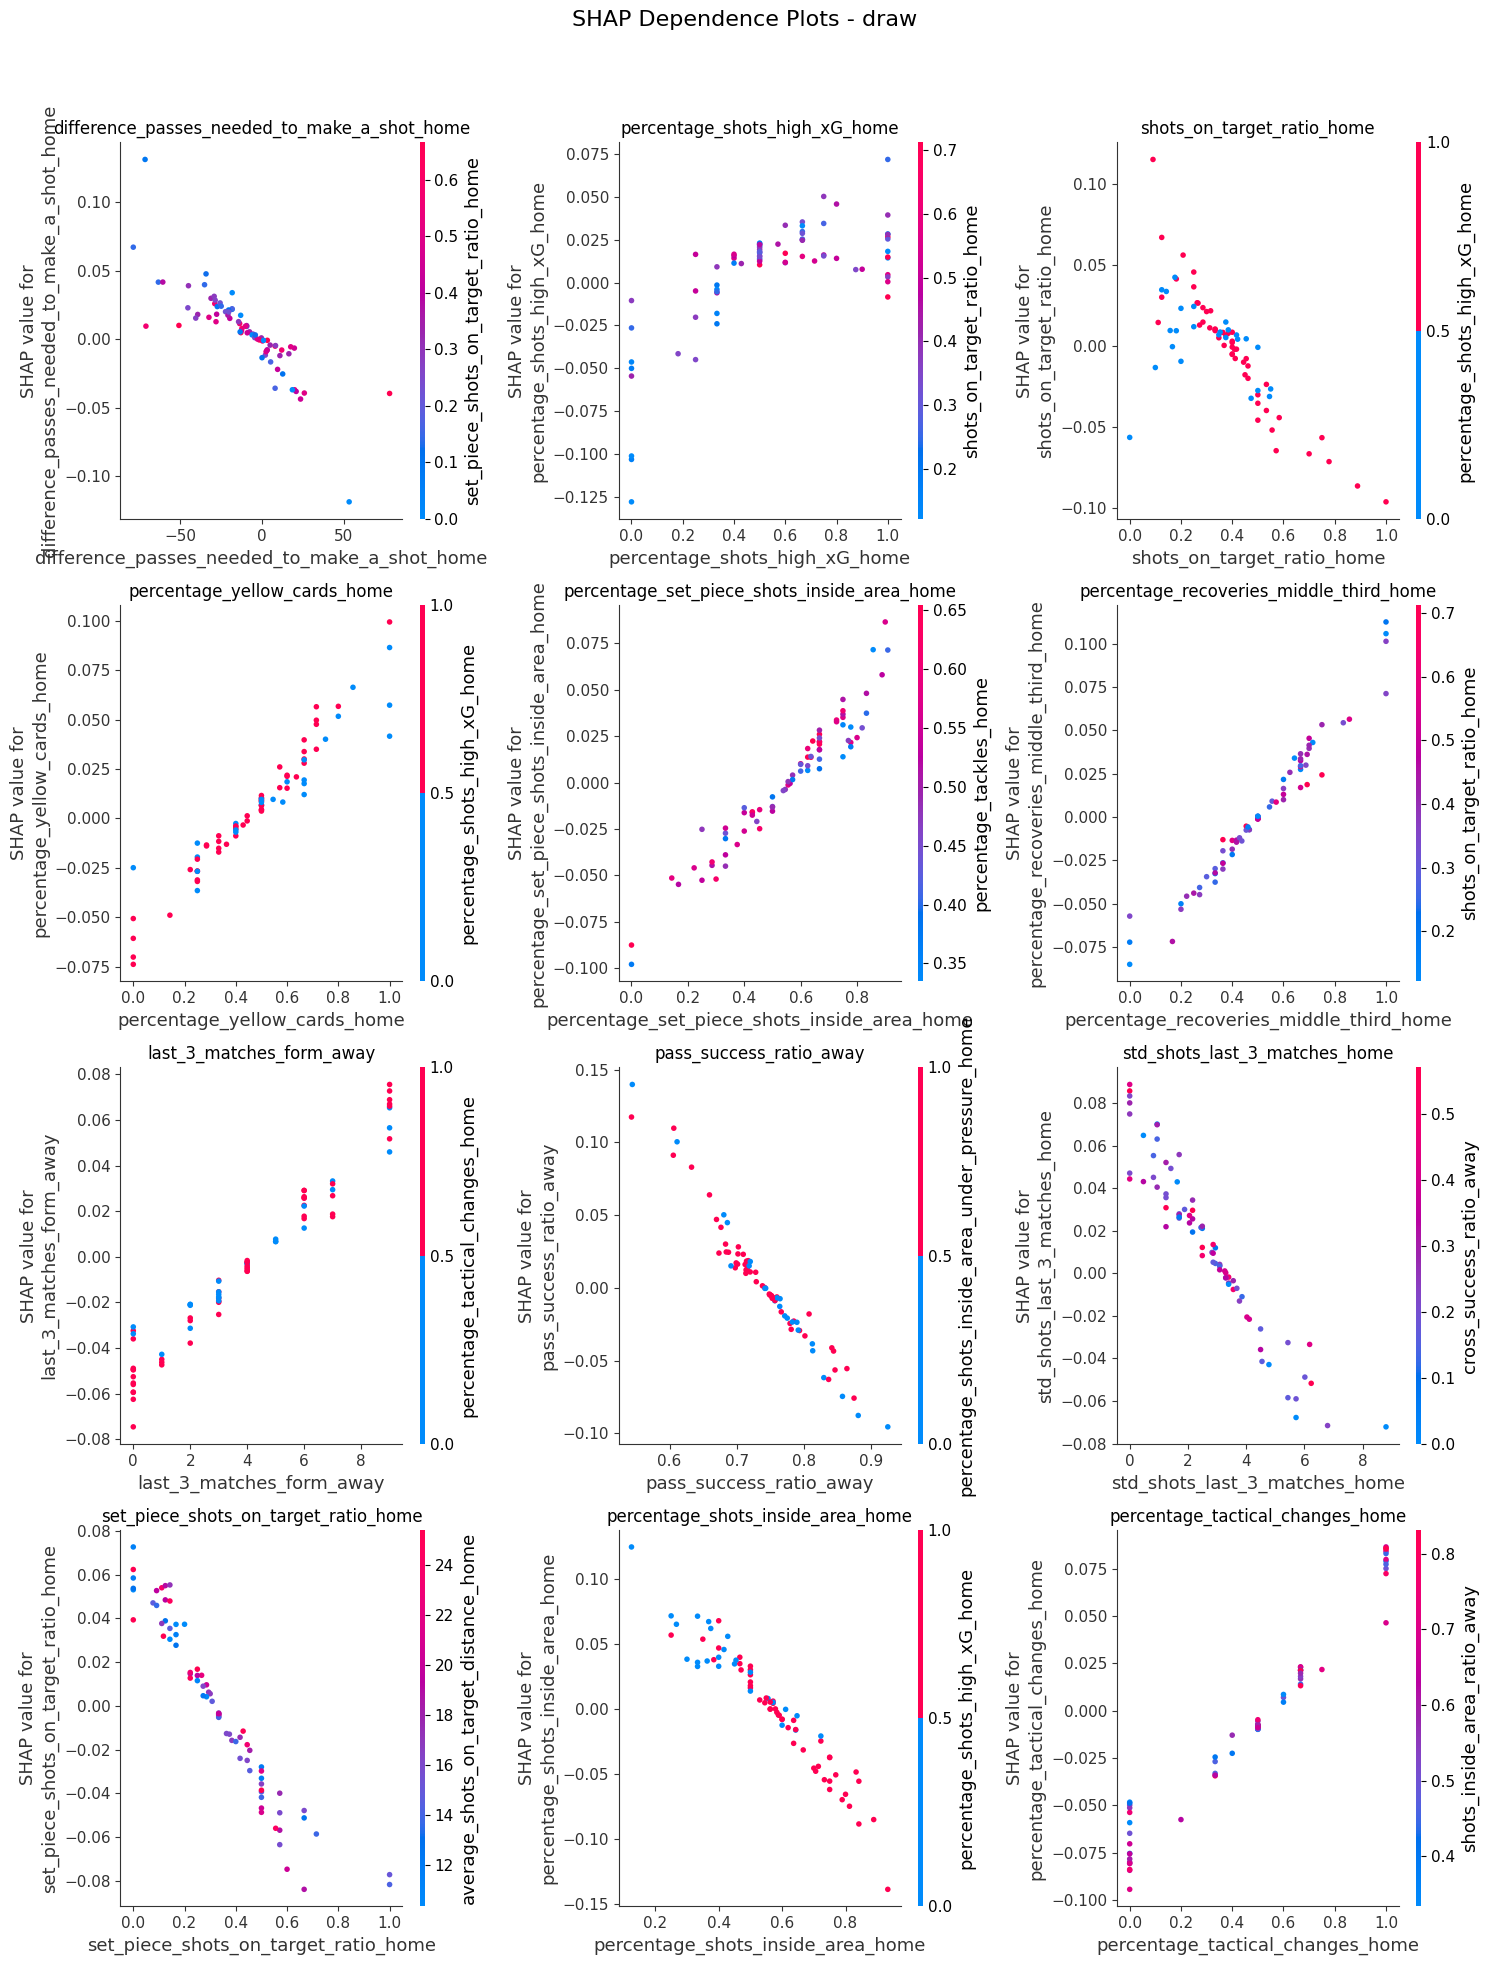


Graphs for class: home_team



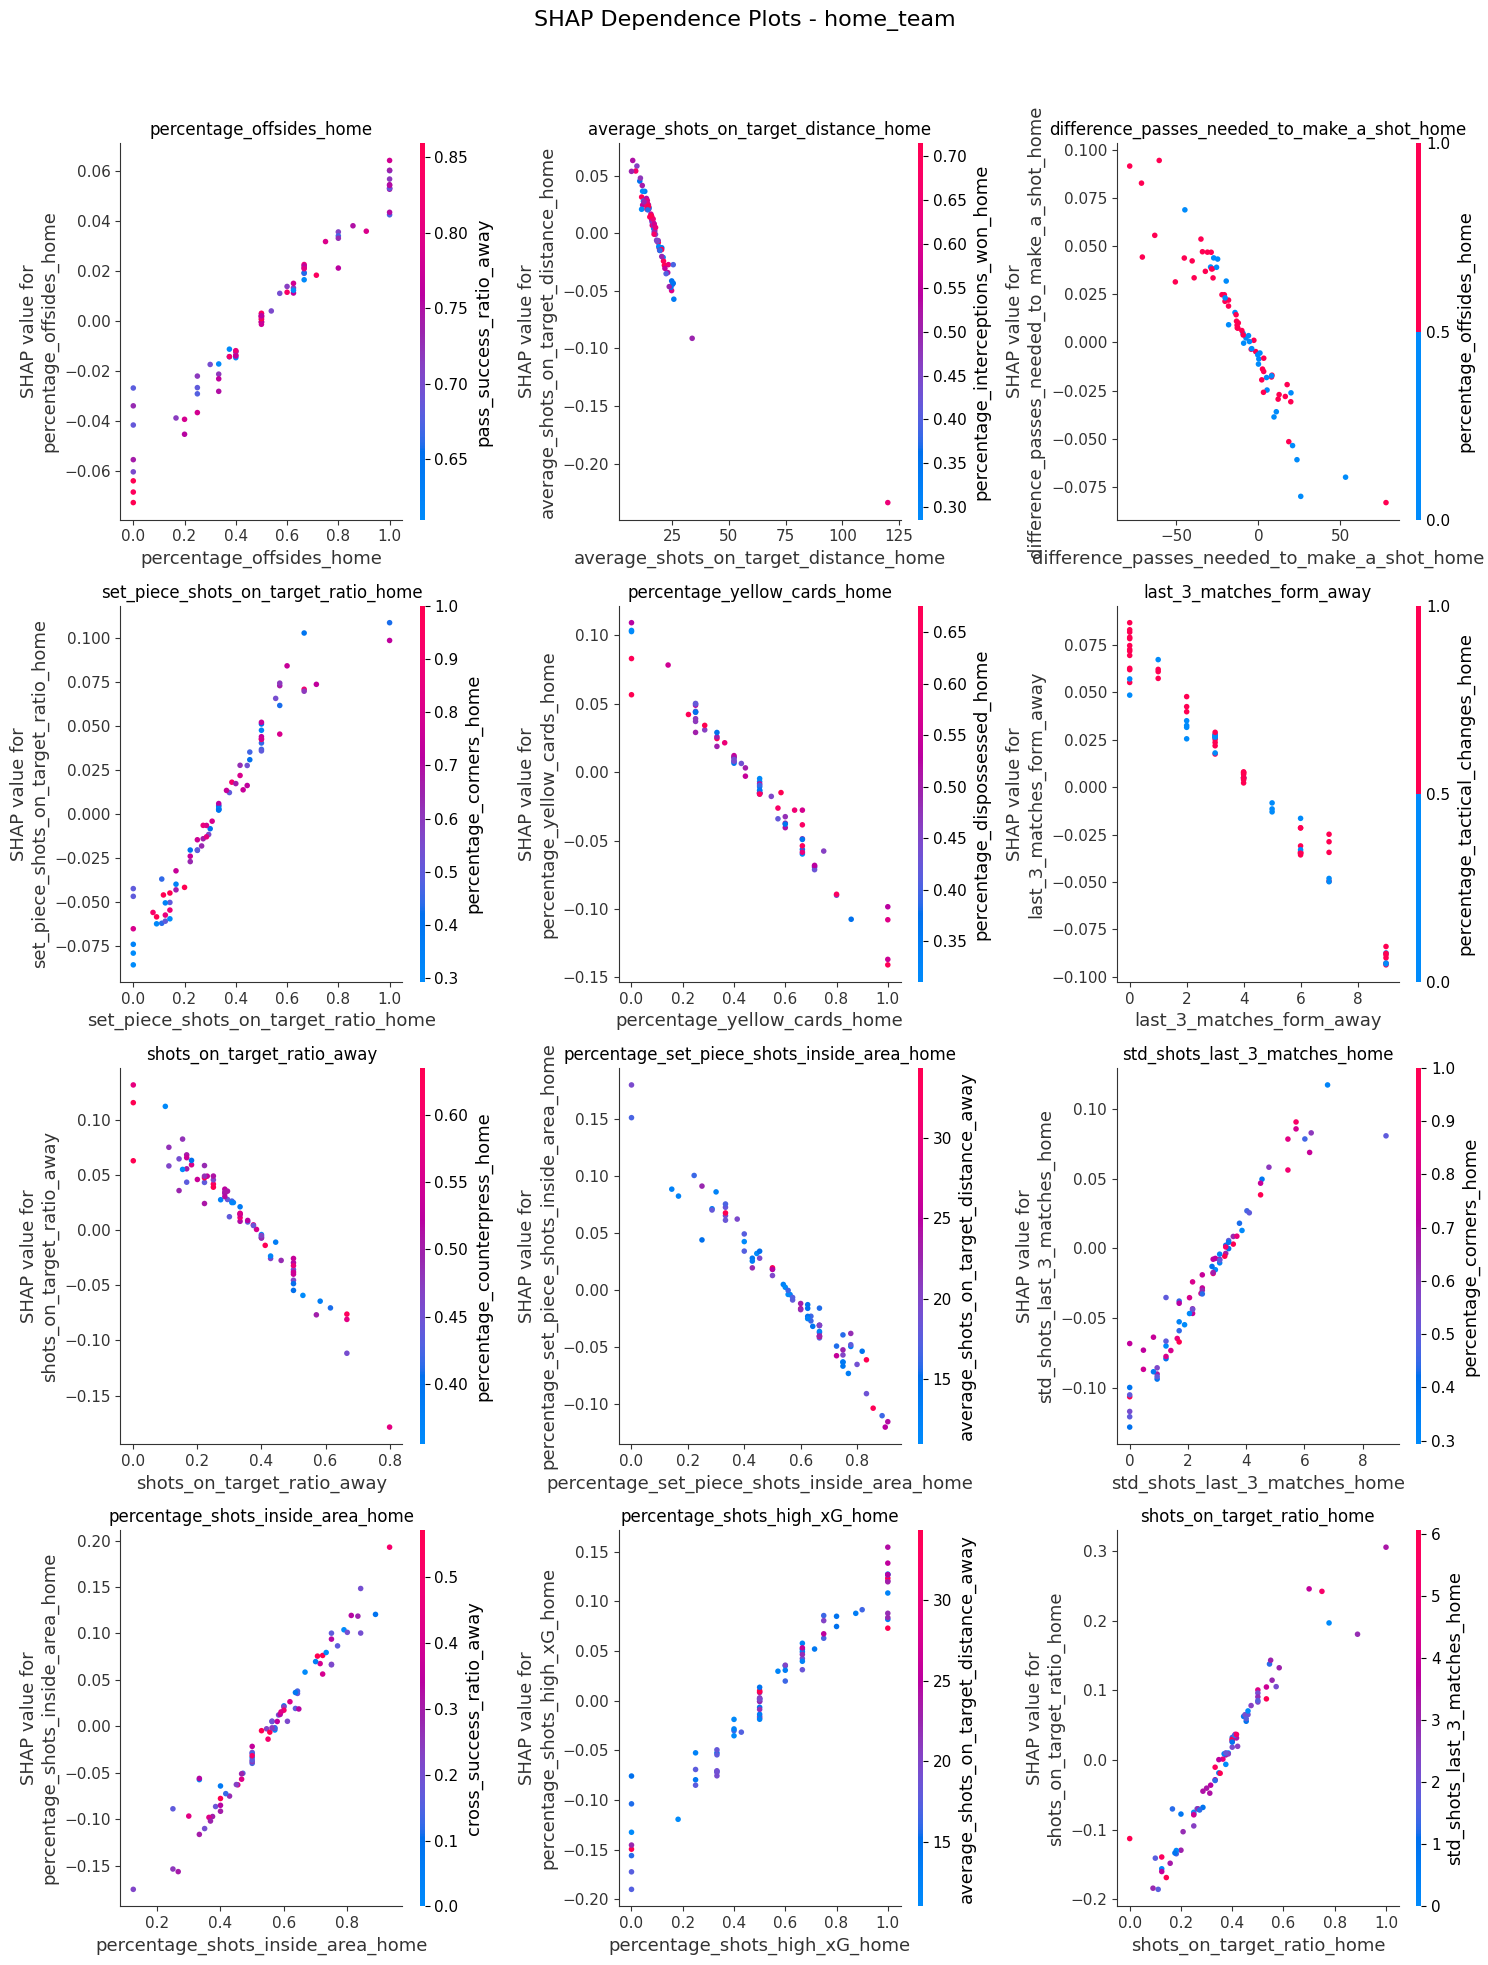

In [8]:
import matplotlib.pyplot as plt


num_features_to_plot = 12  
# número de columnas y filas para los subgráficos
n_cols = 3
n_rows = (num_features_to_plot // n_cols) + (num_features_to_plot % n_cols > 0)

for class_idx in range(shap_values_LaLiga.shape[2]):
    class_name = encoder_LaLiga.inverse_transform([class_idx])[0]  
    print(f"\nGraphs for class: {class_name}\n")

    # seleccionamos las características más importantes para esta clase específica
    shap_importance = np.abs(shap_values_LaLiga.values[:, :, class_idx]).mean(axis=0)
    top_features = np.argsort(shap_importance)[-num_features_to_plot:]  

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    for i, feature_idx in enumerate(top_features):
        feature_name = feature_names_reduced_LaLiga[feature_idx]
        ax = axes[i]
        shap.dependence_plot(
            feature_name, 
            shap_values_LaLiga.values[:, :, class_idx],  
            X_test_reduced_orig_LaLiga,  # utilizamos los datos sin normalizar
            feature_names=feature_names_reduced_LaLiga, 
            ax=ax,
            show=False
        )
        ax.set_title(f"{feature_name}")

    plt.suptitle(f"SHAP Dependence Plots - {class_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()